In [ ]:
import pandas as pd

# Load the penguins dataset, dropping nan values
penguins_df = pd.read_csv("penguins.csv").dropna().reset_index(drop=True)
penguins_df.head()

In [ ]:
import umap
from sklearn.preprocessing import MinMaxScaler

# Separate the features and target
X = penguins_df.drop(columns=['species'])
y = penguins_df['species']

# One-hot encoding all string columns
X = pd.get_dummies(X)

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Embedding using UMAP with the normalized data
embedding = umap.UMAP(min_dist=0.75).fit_transform(X_normalized)
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

penguins_df['x'] = embedding_df['UMAP1']
penguins_df['y'] = embedding_df['UMAP2']

penguins_df.head()


In [ ]:
import altair as alt

# Create a simple scatter plot
alt.Chart(penguins_df).mark_circle().encode(
    x='x',
    y='y',
    color='species',
    tooltip=['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
).interactive()

In [ ]:
from sklearn.cluster import KMeans

# Use k-means to cluster the data based on the UMAP embeddings
kmeans = KMeans(n_clusters=9)
kmeans.fit(embedding)

# Add the cluster labels to the dataframe
penguins_df['kmeans'] = kmeans.labels_

# Create the scatter plot
alt.Chart(penguins_df).mark_circle().encode(
    x='x',
    y='y',
    color='kmeans:N',
    tooltip=['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
).interactive()

In [ ]:
import hdbscan

# Perform HDBSCAN clustering
clusterer = hdbscan.HDBSCAN()  # you can adjust min_samples parameter as needed
clusters = clusterer.fit_predict(embedding)
penguins_df['hdbscan'] = clusters

# Create the scatter plot
alt.Chart(penguins_df).mark_circle().encode(
    x='x',
    y='y',
    color='hdbscan:N',
    tooltip=['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
).interactive()

In [ ]:
# Here we prepare the code for superimposing images of penguins onto the scatter plot
import os

# Define a dictionary with species names as keys and hardcoded filenames as values
image_files = {
    'Adelie': 'images/adelie.webp',
    'Chinstrap': 'images/chinstrap.webp',
    'Gentoo': 'images/gentoo.jpg'
}


def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


# function for creating a dataframe of positions, penguin images, text to be displayed with the image
def create_image_df(df, output_dir='output_images'):
    ensure_dir(output_dir)  # Ensure the output directory exists
    image_data = []
    
    for cluster in df['hdbscan'].unique():
        if cluster != -1:  # Excluding the -1 cluster which represents outliers
            cluster_data = df[df['hdbscan'] == cluster]
            most_common_species = cluster_data['species'].value_counts().idxmax()
            
            # Position the image in the center of the cluster
            x_mean, y_mean = cluster_data[['x', 'y']].mean()
            
            # Get the image paths from the dictionary and output directory
            img_path_species = image_files.get(most_common_species, None)
            
            if img_path_species:
                # Creating and saving the new image and getting the new image path
                image_data.append({
                    'x': x_mean,
                    'y': y_mean,
                    'img': img_path_species,
                    'text': f"Species: {most_common_species}"
                })
            
    return pd.DataFrame(image_data)


In [ ]:
# Create the image dataframe
image_df = create_image_df(penguins_df)

# Create the scatter plot
scatter_plot = alt.Chart(penguins_df).mark_point().encode(
    x='x',
    y='y',
    color='species:N',  # use species for color
    shape='hdbscan:N',  # use hdbscan for shape
    tooltip=['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
).interactive()

# Create the image plot
image_plot = alt.Chart(image_df).mark_image(
    width=50,
    height=50
).encode(
    x='x',
    y='y',
    url='img'
).properties(
    width=750,
    height=750
)

# Create the text plot
text_plot = alt.Chart(image_df).mark_text(
    dy=-30  # Adjust the position of the text relative to the image
).encode(
    x='x',
    y='y',
    text='text'
)

# Combine and display the plots
(scatter_plot + image_plot + text_plot).display()

In [ ]:
# We can also directly show feature distribution visualizations for each cluster
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

def create_image_df_density(df, output_dir='output_images', numerical_feature='body_mass_g'):
    ensure_dir(output_dir)  # Ensure the output directory exists
    image_data = []
    
    for cluster in df['hdbscan'].unique():
        if cluster != -1:  # Excluding the -1 cluster which represents outliers
            cluster_data = df[df['hdbscan'] == cluster]
            
            x_mean, y_mean = cluster_data[['x', 'y']].mean()
            
            # Creating density plot for body_mass_g
            plt.figure(figsize=(6, 4))
            sns.kdeplot(cluster_data[numerical_feature], fill=True)
            sns.kdeplot(df[numerical_feature], fill=True, color='grey')
            plt.title(f'Density Plot of body_mass_g for Cluster {cluster}')
            plt.xlabel('Body Mass (g)')
            plt.ylabel('Density')
            plt.xlim(df[numerical_feature].min(), df[numerical_feature].max())
            
            # Save the plot to the output directory
            img_path_density = os.path.join(output_dir, f'density_plot_cluster_{cluster}.png')
            plt.savefig(img_path_density)
            plt.close()
            
            # Append the path of the saved plot to the data list
            image_data.append({
                'x': x_mean,
                'y': y_mean,
                'img': img_path_density,
                'text': f"Cluster: {cluster}"
            })
            
    return pd.DataFrame(image_data)

# Could also show categorical feature distributions via bar charts
# Or create more complex summary visualizations that combine multiple plots



In [ ]:
numerical_feature = 'body_mass_g'

# Create the image dataframe
image_df = create_image_df_density(penguins_df, numerical_feature=numerical_feature)

# Create the scatter plot
scatter_plot = alt.Chart(penguins_df).mark_point().encode(
    x='x',
    y='y',
    color='species:N',  # use species for color
    shape='hdbscan:N',  # use hdbscan for shape
    tooltip=['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
).interactive()

# Create the image plot for the feature distributions
image_plot = alt.Chart(image_df).mark_image(
    width=125,
    height=125,
).encode(
    x='x',
    y='y',
    url='img'
).properties(
    width=750,
    height=750,
    title=str(numerical_feature) + " per Cluster"
)

# Create the text plot
text_plot = alt.Chart(image_df).mark_text(
    dy=-30  # Adjust the position of the text relative to the image
).encode(
    x='x',
    y='y',
    text='text'
)

# Combine and display the plots
(scatter_plot + image_plot).display()

# Using Complex Glyphs
[See for instance "Out of the Plane: Flower vs. Star Glyphs to Support High-Dimensional Exploration in Two-Dimensional Embeddings" by van Onzenoodt et al. from EuroVis 2023](https://ieeexplore.ieee.org/document/9930144)

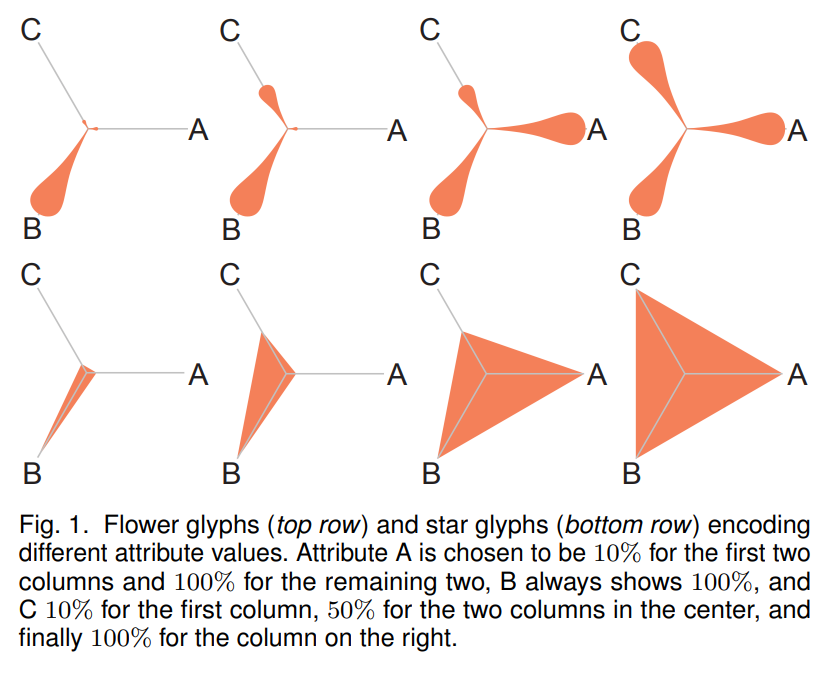

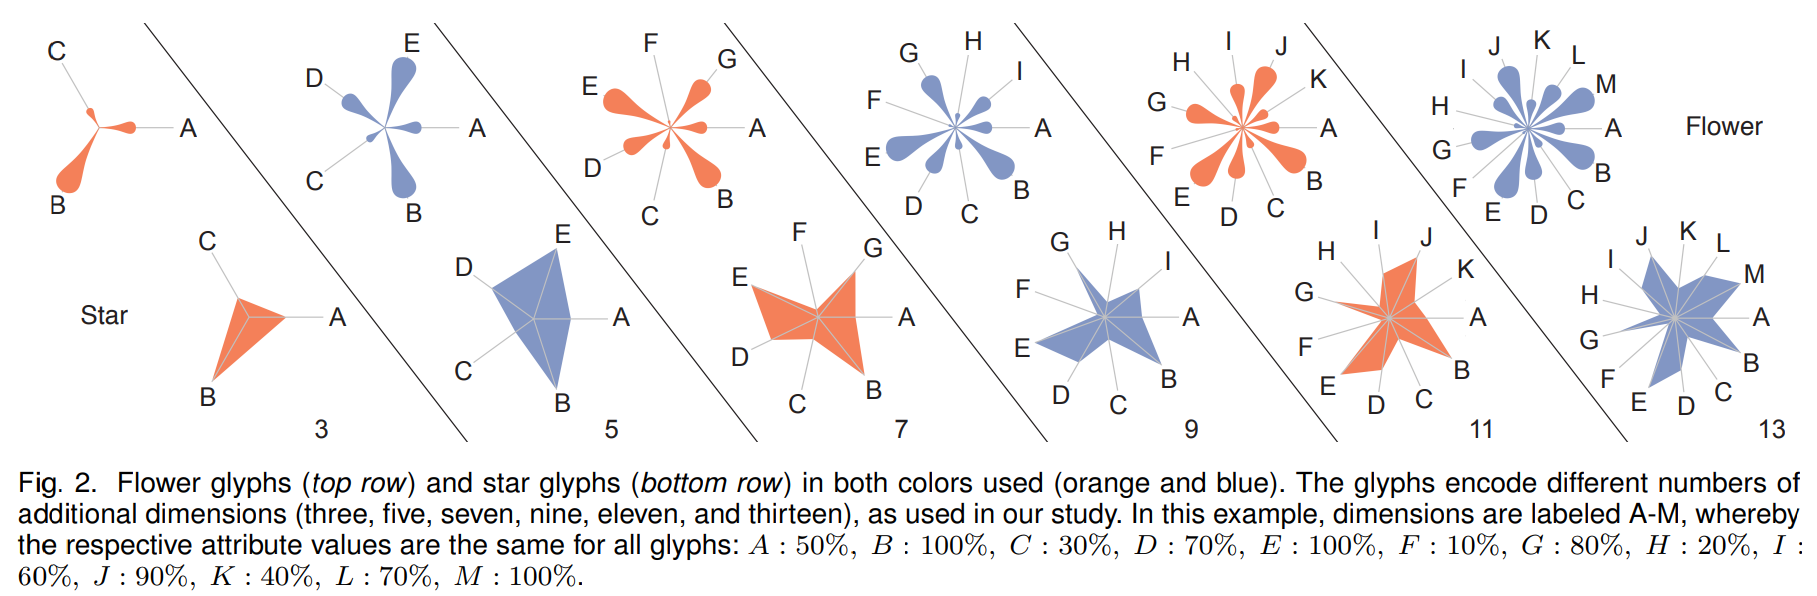

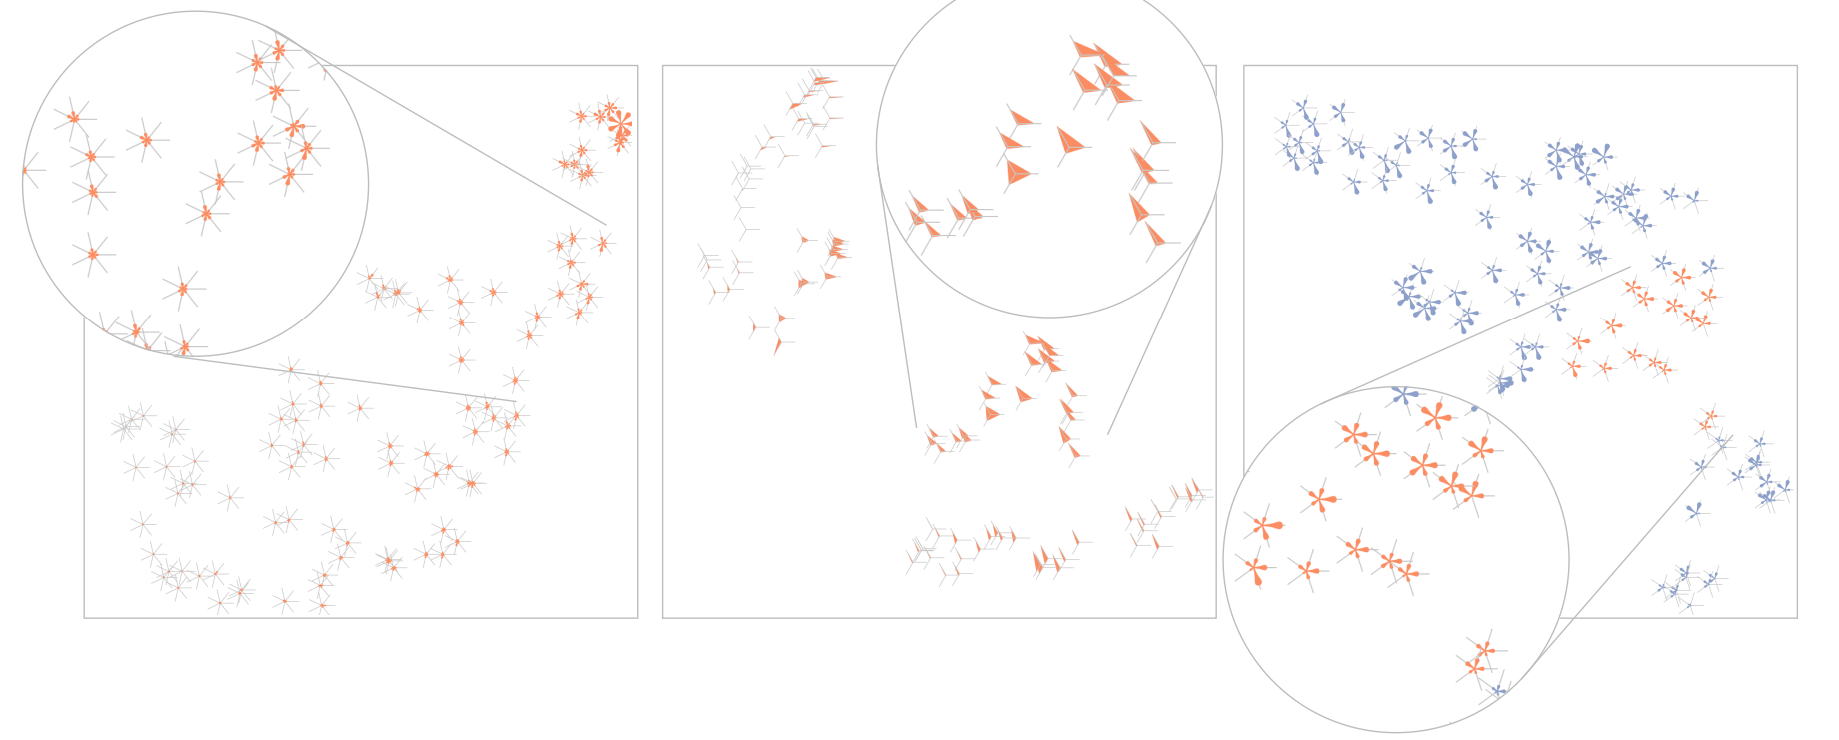
